# 미래에 볼 영화의 평점 예측

## 데이터 탐색

In [1]:
%matplotlib inline

import time
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

rating_file_path = "../python-data-analysis/data/ml-1m/ratings.dat"
movie_file_path = "../python-data-analysis/data/ml-1m/movies.dat"
user_file_path = "../python-data-analysis/data/ml-1m/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, 
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', encoding = "ISO-8859-1")
movie_data = pd.io.parsers.read_csv(movie_file_path, 
                                    names=['movie_id', 'title', 'genre'], delimiter='::', encoding = "ISO-8859-1")
user_data = pd.io.parsers.read_csv(user_file_path, 
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::', encoding = "ISO-8859-1")

In [2]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


## 데이터 분석

In [5]:
# 영화의 개수
print("total number of movie in data:", len(movie_data['movie_id'].unique()))

# 영화가 많은 연도 TOP 10
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data: 3883


year
1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: count, dtype: int64

In [6]:
# 연대별 영화의 개수를 출력합니다.
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
movie_data['year_term'].value_counts().sort_index()

year_term
1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: count, dtype: int64

In [7]:
# 많이 사용된 장르 조합 TOP10
movie_data['genre'].value_counts()[:10]

genre
Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: count, dtype: int64

In [8]:
# 장르 조합 분리해서 개수 세기
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")

    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1

print(unique_genre_dict)

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


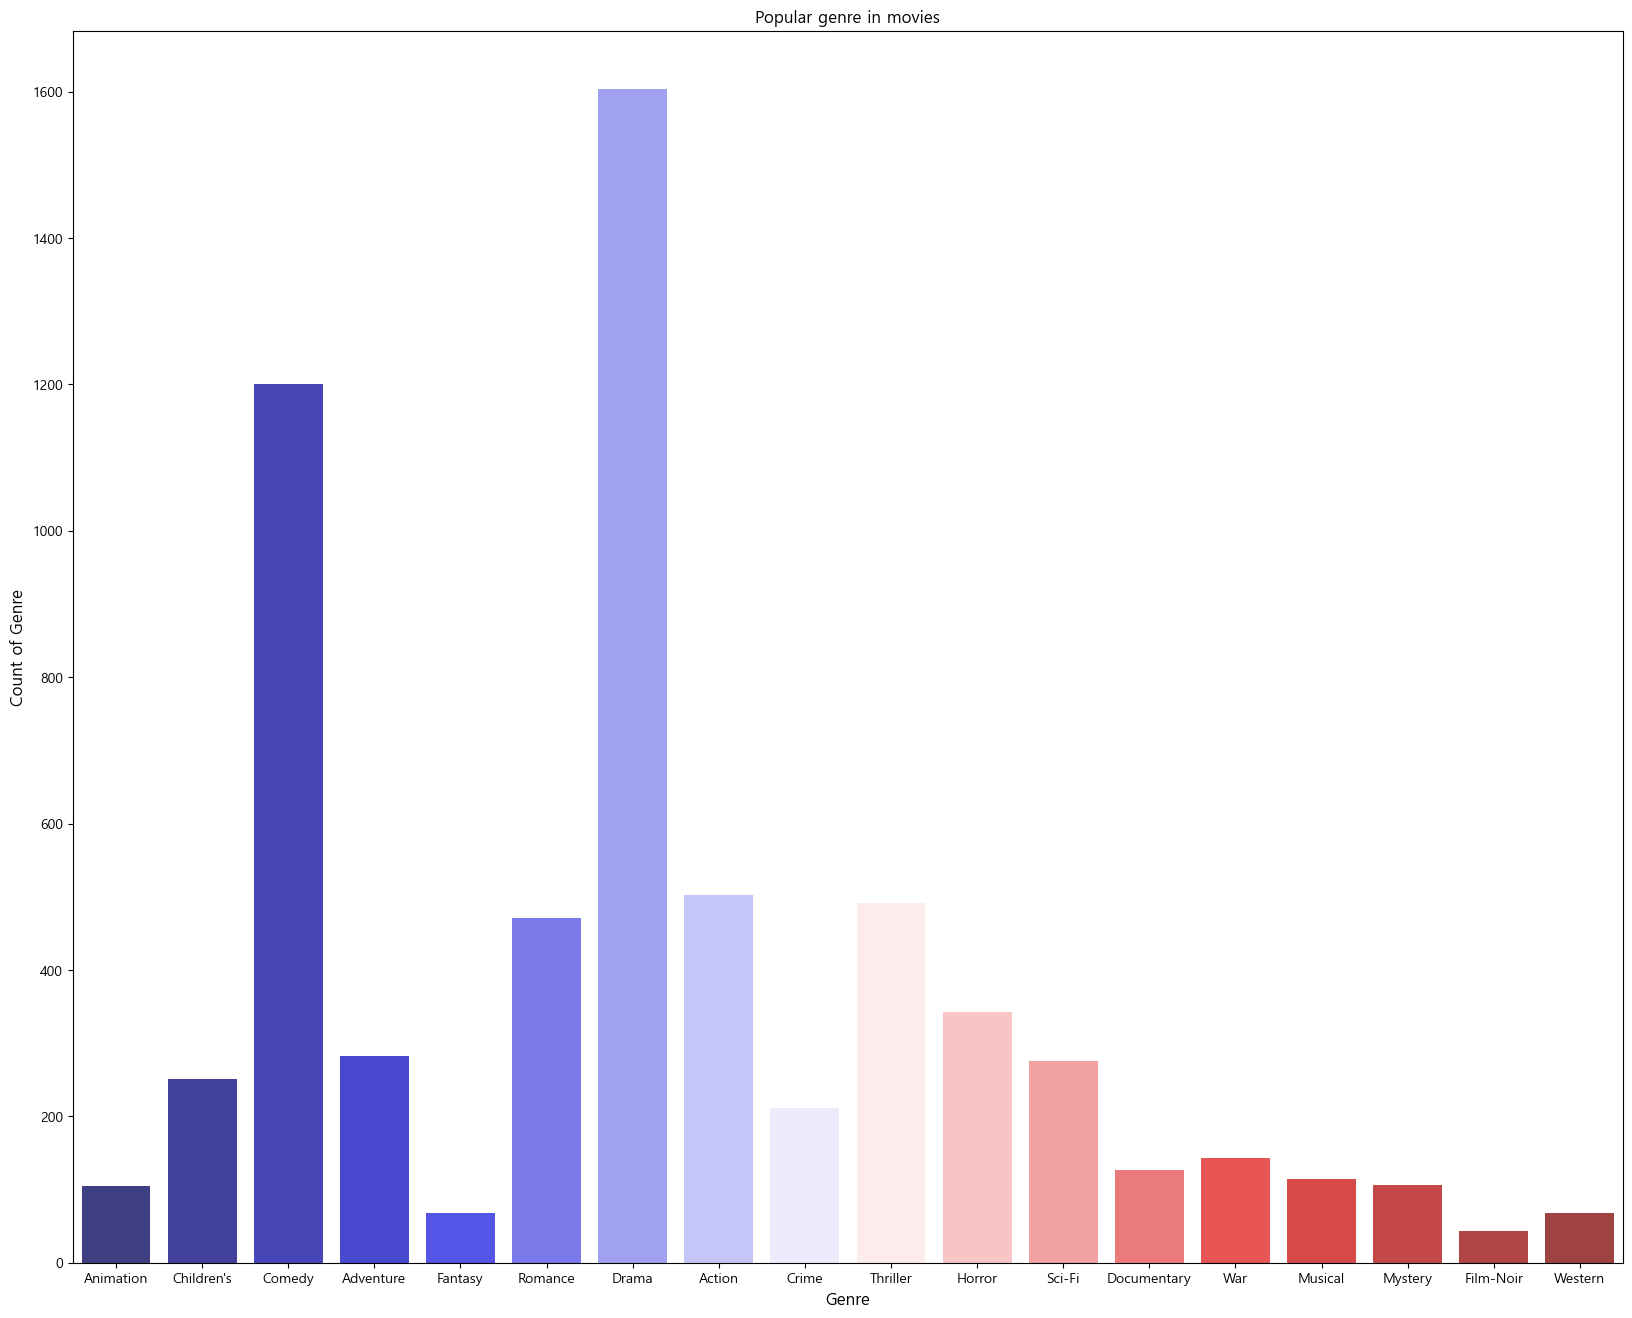

In [9]:
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(x=list(unique_genre_dict.keys()), y=list(unique_genre_dict.values()), alpha=0.8, palette='seismic')
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

In [10]:
# 유저의 수 분석
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


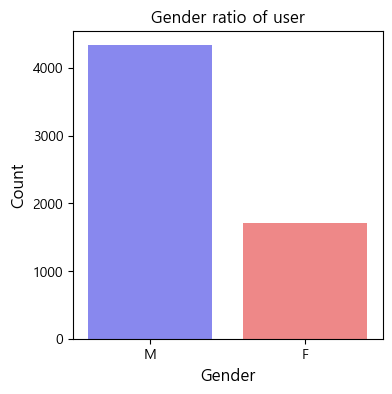

In [11]:
plt.rcParams['figure.figsize'] = [4, 4]
user_gender = user_data['gender'].value_counts()
sns.barplot(x=user_gender.index, y=user_gender.values, alpha=0.8, palette='seismic')
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [12]:
# 유저의 연령대 탐색
user_data['age'].value_counts()

age
25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: count, dtype: int64

In [13]:
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

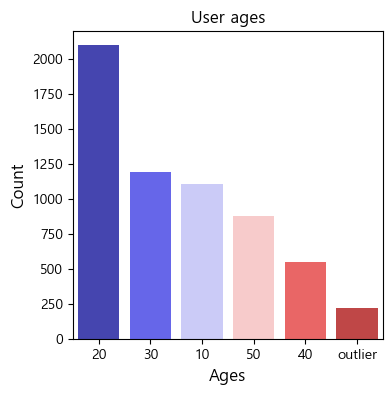

In [14]:
sns.barplot(x=user_ages.index, y=user_ages.values, alpha=0.8, palette='seismic')
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

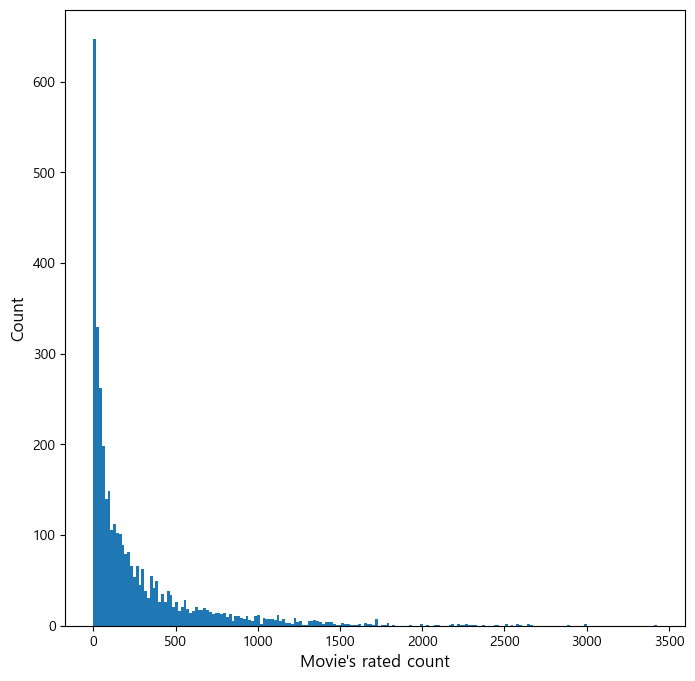

In [18]:
# 각 영화가 평가받은 횟수
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [19]:
print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data : 3883
total number of movie rated below 100 : 1687


In [20]:
# 영화별 평점 평균
movie_grouped_rating_info = rating_data.groupby('movie_id')['rating'].agg(['count', 'mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']
movie_grouped_rating_info.head()

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


<Axes: >

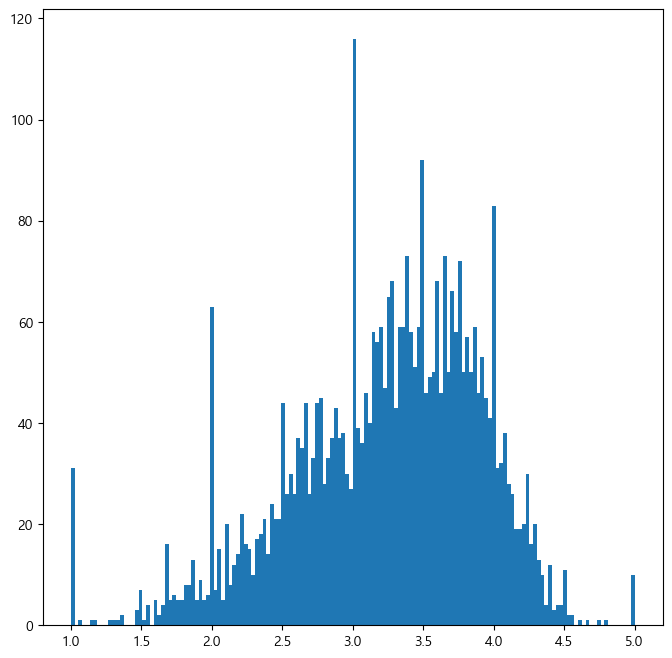

In [21]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

In [25]:
# 100번 이상 평가 받은 영화 중 평점 TOP10
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)


In [28]:
rating_data.head()


,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [31]:
# user_id, movie_id를 축으로 하는 데이터 생성
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(['user_id', 'movie_id']).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

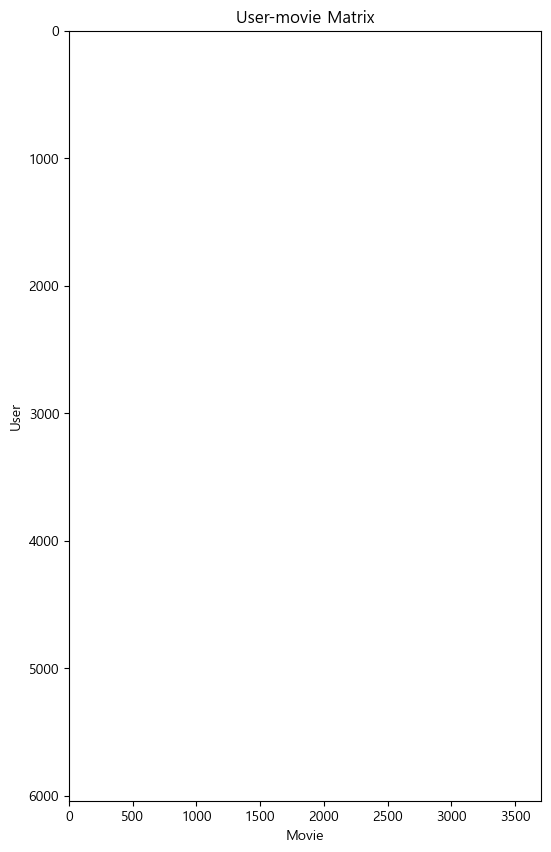

In [36]:
# user-movie 테이블을 시각화
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(rating_table)
plt.grid(False)
plt.xlabel("Movie")
plt.ylabel("User")
plt.title("User-movie Matrix")
plt.show()

- 색이 없는 이유는 대부분의 Rating 값이 Nan 값이기 때문이다

## 예측

In [38]:
!pip install surprise

  Obtaining dependency information for surprise from https://files.pythonhosted.org/packages/61/de/e5cba8682201fcf9c3719a6fdda95693468ed061945493dea2dd37c5618b/surprise-0.1-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/154.4 kB ? eta -:--:--
     -- ------------------------------------- 10.2/154.4 kB ? eta -:--:--
     ------- ----------------------------- 30.7/154.4 kB 660.6 kB/s eta 0:00:01
     -------------------------------------  153.6/154.4 kB 1.5 MB/s eta 0:00:01
     -------------------------------------- 154.4/154.4 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-

In [42]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [45]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

# SVD 사용을 위한 데이터셋을 생성
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(rating_data[["user_id", "movie_id", "rating"]], reader=reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=10)
model.fit(train_data)
train_end = time.time()
print('training time of model: %.2f seconds' % (train_end - train_start))

training time of model: 3.72 seconds


In [46]:
# user4의 영화 평가 데이터
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head()

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [47]:
# user4가 평가한 영화 히스토리
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
            
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


In [49]:
# 타겟 유저가 보지 않은 영화 중, 예상 평점이 높은 10개
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))

In [50]:
# 타겟 유저릐 평점 점수를 예측
target_user_predictions = model.test(test_data)

def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [51]:
# 타겟 유저의 Top 10 영화를 선정
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     key=operator.itemgetter(1), reverse=True)[:10]
target_user_top10_predicted

[(745, 4.7896860345121635),
 (2905, 4.7867262895822345),
 (318, 4.762354900238035),
 (527, 4.72983770408205),
 (1148, 4.7051990348794615),
 (1178, 4.6809653030788745),
 (922, 4.6481021207298605),
 (2019, 4.6467026824084225),
 (904, 4.638079116667055),
 (1207, 4.619450060487084)]

In [54]:
# 타이틀 정보로 출력하기 위함
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title

In [55]:
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)

Close Shave, A (1995) : 4.7896860345121635
Sanjuro (1962) : 4.7867262895822345
Shawshank Redemption, The (1994) : 4.762354900238035
Schindler's List (1993) : 4.72983770408205
Wrong Trousers, The (1993) : 4.7051990348794615
Paths of Glory (1957) : 4.6809653030788745
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) : 4.6481021207298605
Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954) : 4.6467026824084225
Rear Window (1954) : 4.638079116667055
To Kill a Mockingbird (1962) : 4.619450060487084


In [59]:
# 타겟 유저의 기존 선호 영화와 비교
target_user_top10_real = sorted(target_user_movie_rating_dict.items(), 
                                key=operator.itemgetter(1),reverse=True)[:10]
for real in target_user_top10_real:
    movie_id = real[0]
    real_rating = real[1]
    print(movie_dict[movie_id], ":", real_rating)

Hustler, The (1961) : 5
Star Wars: Episode IV - A New Hope (1977) : 5
Saving Private Ryan (1998) : 5
Raiders of the Lost Ark (1981) : 5
Rocky (1976) : 5
Jaws (1975) : 5
Good, The Bad and The Ugly, The (1966) : 5
Run Lola Run (Lola rennt) (1998) : 5
Goldfinger (1964) : 5
Terminator, The (1984) : 5


## 예측 모델 평가

- 행렬 평가의 가장 보편적인 평가 방법: RMSE

In [61]:
# 학습 데이터를 생성
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델 학습.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 49.59 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8583


0.8583097341830719

In [63]:
# 실제 평점과의 비교 시각화

# 타겟 유저 정보 생성
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))

# 타겟 유저의 평점 점수 예측
target_user_predictions = model.test(test_data)

# 타겟 유저의 영화별 점수 저장
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# TOP10 생성
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

In [64]:
target_user_movie_predict_dict

{260: 4.216166886280759,
 480: 3.191799725809924,
 1036: 3.703104610337903,
 1097: 4.397193117218393,
 1196: 3.9348985479835354,
 1198: 4.348388321056414,
 1201: 4.495883974463497,
 1210: 3.4539398360152247,
 1214: 4.187419338586568,
 1240: 3.9760525719598374,
 1387: 4.3459129316215765,
 1954: 4.270155411145849,
 2028: 4.482848253328754,
 2366: 4.083004989675109,
 2692: 4.198444228202058,
 2947: 4.248299383673807,
 2951: 4.242897335680194,
 3418: 4.072209025097312,
 3468: 4.865865258499344,
 3527: 3.1355173607576123,
 3702: 3.7979116495836003}

In [65]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.22
movie 2 : Jurassic Park (1993) - 4 / 3.19
movie 3 : Die Hard (1988) - 4 / 3.7
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.4
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 3.93
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.35
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.5
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.45
movie 9 : Alien (1979) - 4 / 4.19
movie 10 : Terminator, The (1984) - 5 / 3.98
movie 11 : Jaws (1975) - 5 / 4.35
movie 12 : Rocky (1976) - 5 / 4.27
movie 13 : Saving Private Ryan (1998) - 5 / 4.48
movie 14 : King Kong (1933) - 4 / 4.08
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.2
movie 16 : Goldfinger (1964) - 5 / 4.25
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.24
movie 18 : Thelma & Louise (1991) - 4 / 4.07
movie 19 : Hustler, The (1961) - 5 / 4.87
movie 20 : Predator (1987) - 1 / 3.14
movie 21 : Mad Max (1979) - 4 / 3.8


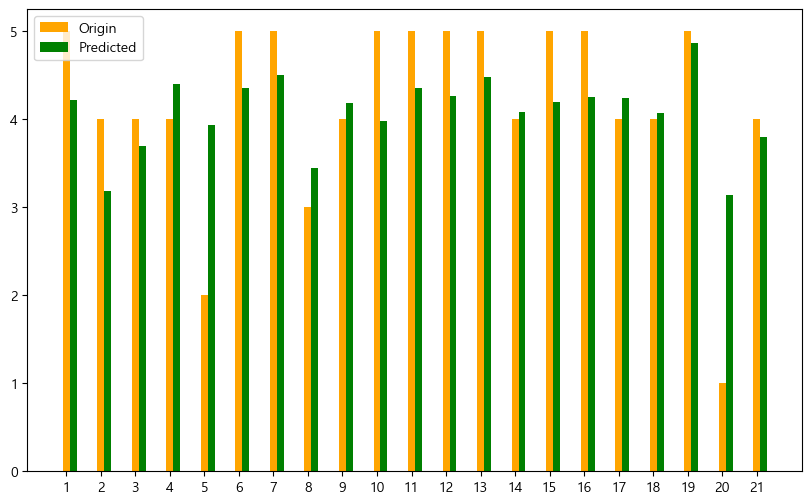

In [66]:
# 시각화
origin = origin_rating_list
predicted = predicted_rating_list
 
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2
 
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()